In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = (15, 6)

### 读取数据

将代表日期的列, 作为index, 并根据日期的格式转换为`DatetimeIndex`格式, 这样在后续的操作中很方便.

In [3]:
data = pd.read_csv("AirPassengers.csv", index_col="Month", date_parser=lambda x: pd.datetime.strptime(x, "%Y-%m"))
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [5]:
data = data["#Passengers"]

### 画图分析

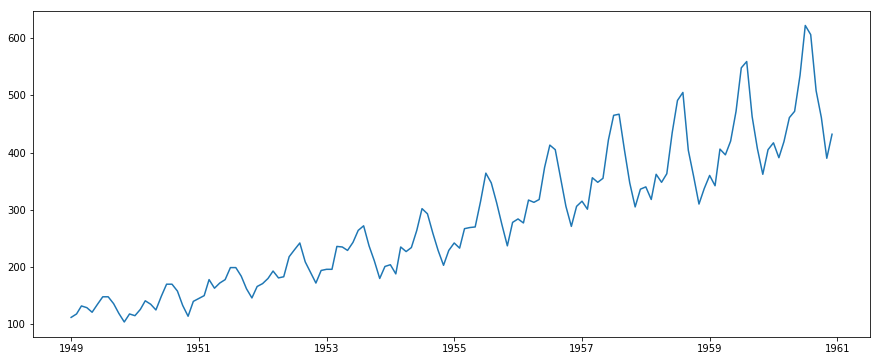

In [6]:
plt.plot(data)

可以看出两点:

- 有很强的趋势性, 因此肯定不是平稳序列, 需要进行转换处理, 成为平稳序列
- 有季节性

### 检测平稳性

因为后面要多次使用, 所以封装成一个函数

In [7]:
from statsmodels.tsa.stattools import adfuller

In [8]:
def test_stationarity(ts, window=12):
    rolling_mean = ts.rolling(window=window).mean()
    rolling_std = ts.rolling(window=window).std()
    
    plt.plot(ts, color='blue',label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    
    adf_result = adfuller(ts, autolag="AIC")
    pd_result = pd.Series(adf_result[:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    pd_result = pd.concat([pd_result, pd.Series(adf_result[4])])
    return pd_result

`adfuller`函数返回6个值, 分别代表:
- adf : float
    - Test statistic
- pvalue : float
    - MacKinnon's approximate p-value based on MacKinnon (1994, 2010)
- usedlag : int
    - Number of lags used
- nobs : int
    - Number of observations used for the ADF regression and calculation of the critical values
- critical values : dict
    - Critical values for the test statistic at the 1 %, 5 %, and 10 % levels. Based on MacKinnon (2010)
- icbest : float
    - The maximized information criterion if autolag is not None.

Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
1%                              -3.481682
5%                              -2.884042
10%                             -2.578770
dtype: float64

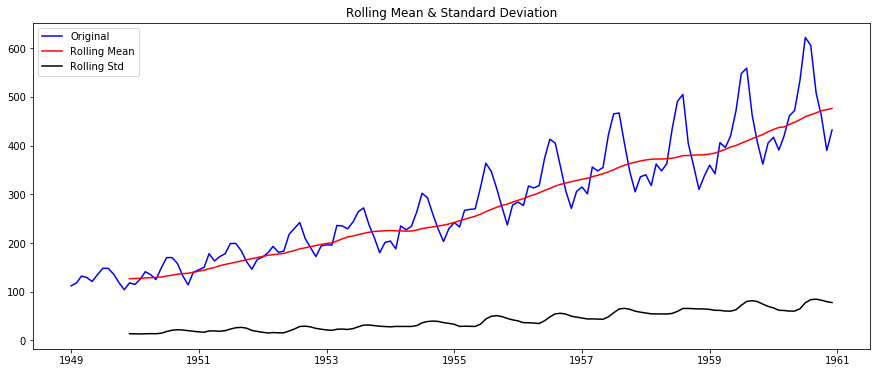

In [9]:
test_stationarity(data)

单位根检验的结果是不平稳的, 因此要把这个非平稳序列, 转换成平稳序列

### 转换为平稳序列

- 首先通过**转换函数**, 如$log$函数来转换, 缩小值域中的差距

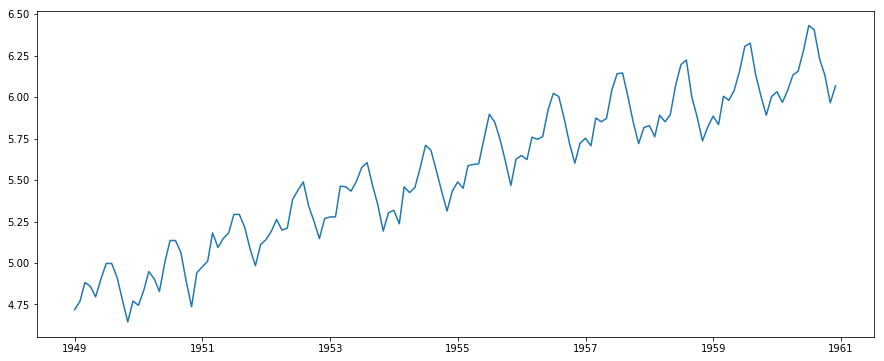

In [10]:
ts = data.copy()
ts_log = np.log(ts)
plt.plot(ts_log)

- 通过**移动平均**的方法进行平滑, 得到趋势, 然后在原有的序列中移除趋势.

这时因为趋势是造成时间序列不平稳的一个重要因素

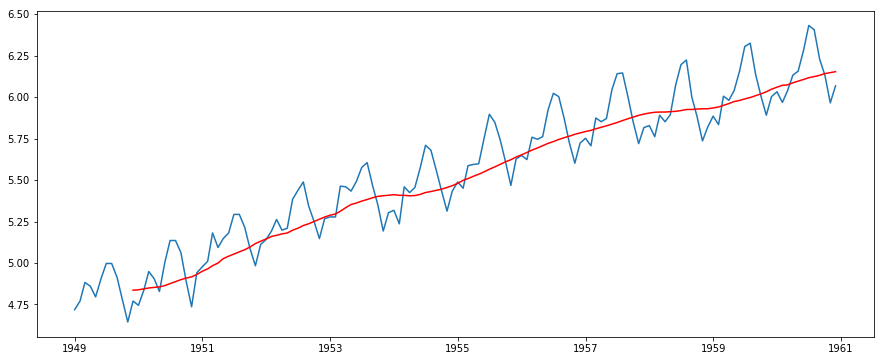

In [11]:
moving_avg = ts_log.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color="red")

In [12]:
ts_log_ma_diff = ts_log - moving_avg
ts_log_ma_diff.head(15)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
Name: #Passengers, dtype: float64

因为我们使用了时间作为索引, 所以可以直接相减, 而不用人工进行对齐, 从而大大方便了操作.

之后抛弃掉这些为空的时间点. 因此使用这种方法抛弃趋势, 会造成**样本的损失**, 损失数量与求移动平均时的窗口大小有关.

Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
1%                              -3.486535
5%                              -2.886151
10%                             -2.579896
dtype: float64

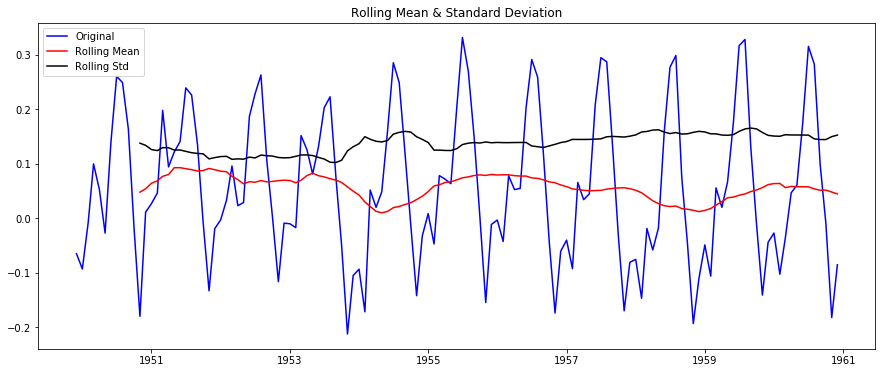

In [13]:
ts_log_ma_diff.dropna(inplace=True)
test_stationarity(ts_log_ma_diff)

也可以使用带权值的平均方法, 这样就不会造成样本的损失了, 如EWMA等.

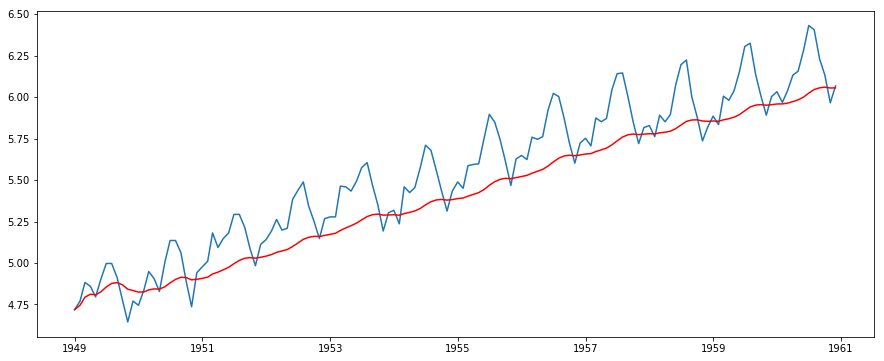

In [14]:
exp_weighted_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(exp_weighted_avg, color="red")

Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
1%                              -3.481682
5%                              -2.884042
10%                             -2.578770
dtype: float64

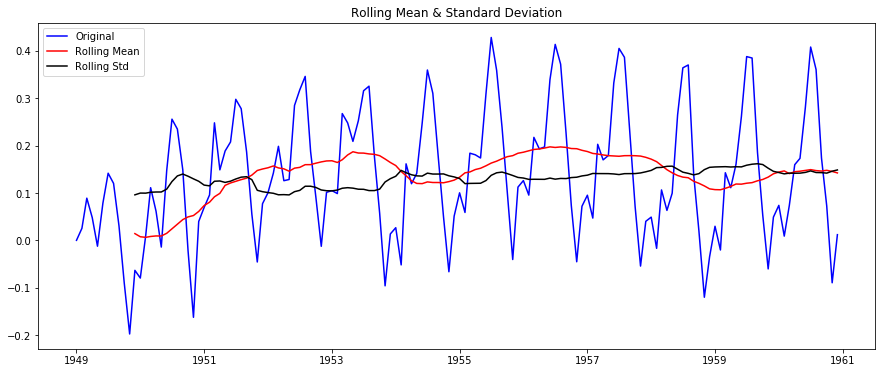

In [15]:
ts_log_ewma_diff = ts_log - exp_weighted_avg
test_stationarity(ts_log_ewma_diff)

使用**EWMA**方法得到的序列, 单位根检验得到P值只有0.0057, 小于1%, 因此是平稳的.

- 使用差分

当然, 差分也会造成样本点的损失, 损失的数量为差分的阶数.

首先进行**一阶差分**:

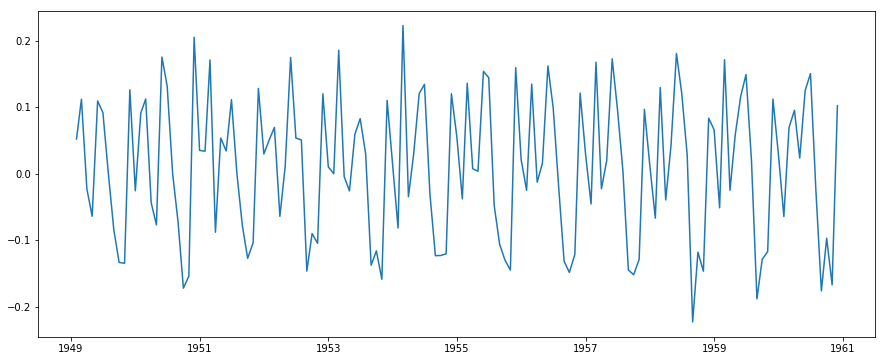

In [16]:
ts_log_diff = ts_log.diff()
ts_log_diff.dropna(inplace=True)
plt.plot(ts_log_diff)

Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
1%                              -3.482501
5%                              -2.884398
10%                             -2.578960
dtype: float64

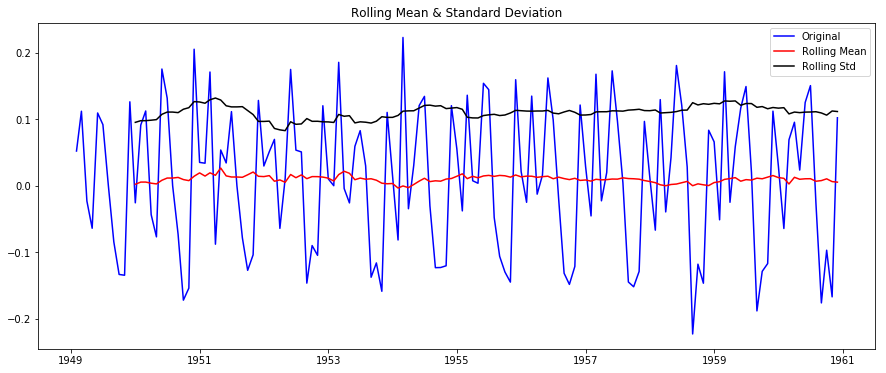

In [17]:
test_stationarity(ts_log_diff)

看出, 如果以5%的显著性水平来判断, 此时的序列仍然是不平稳的.

再进行一次差分, 即使用**二阶差分**, 方法就是对一阶差分得到的序列再次进行差分. 更高阶的差分依次类推.

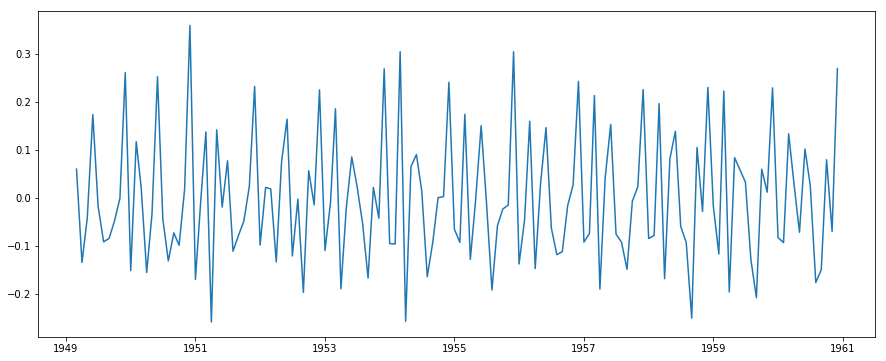

In [18]:
ts_log_diff2 = ts_log_diff.diff()
ts_log_diff2.dropna(inplace=True)
plt.plot(ts_log_diff2)

Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
1%                            -3.482501e+00
5%                            -2.884398e+00
10%                           -2.578960e+00
dtype: float64

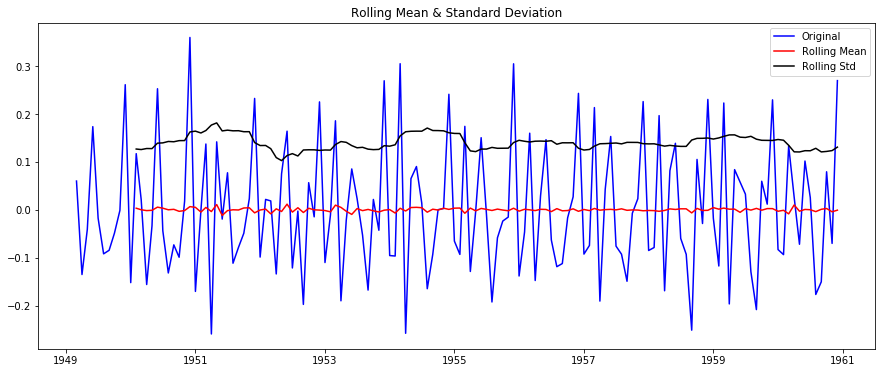

In [19]:
test_stationarity(ts_log_diff2)

现在的效果就非常好了.

- 分解方法

对时间序列进行分解, 分解成**趋势**, **季节性**, **残差**三部分, 剩余的残差部分就是我们需要继续分析建模的.

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [21]:
decomposition = seasonal_decompose(ts_log)
decomposition

In [22]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

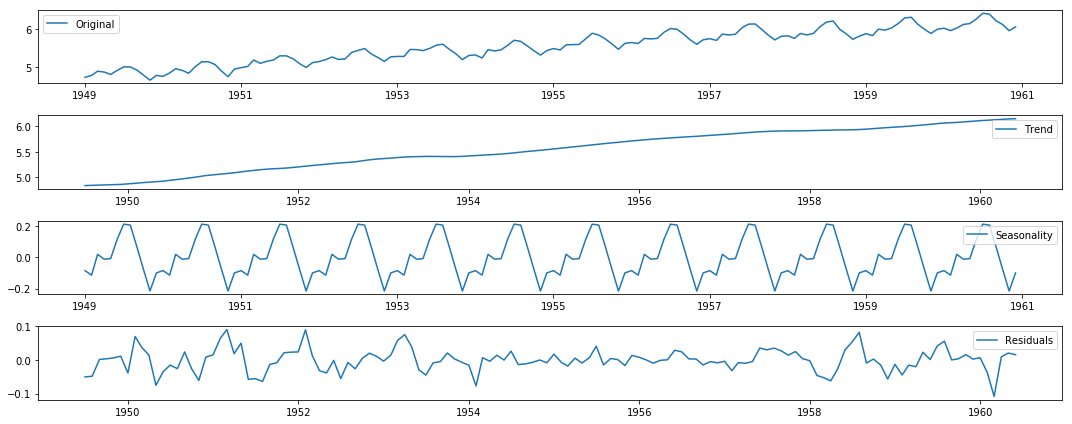

In [23]:
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

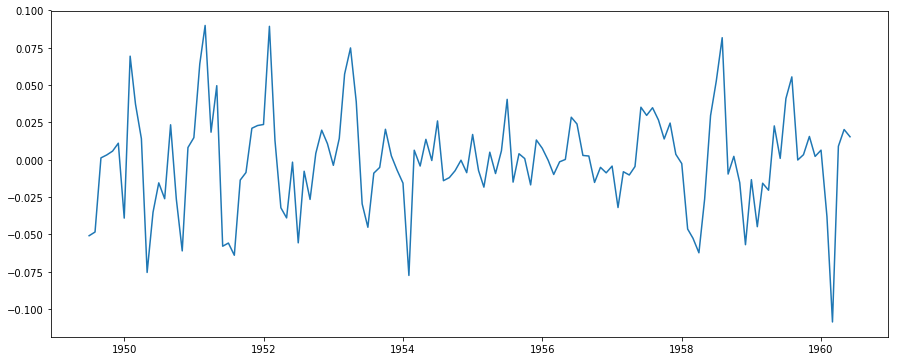

In [24]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
plt.plot(ts_log_decompose)

Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
1%                            -3.485122e+00
5%                            -2.885538e+00
10%                           -2.579569e+00
dtype: float64

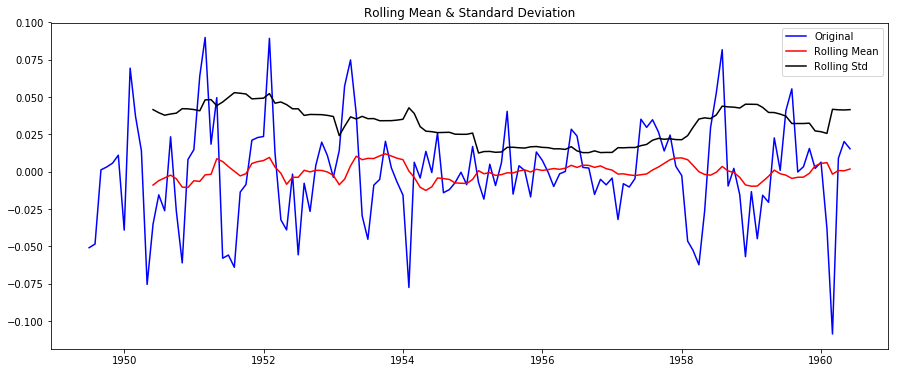

In [25]:
test_stationarity(ts_log_decompose)

### 使用ARIMA模型拟合时间序列

对平稳的时间序列进行拟合.

为了确定模型的`p`, `q`参数, 需要观察**ACF**和**PACF**图.

使用二阶差分得到的平稳的时间序列进行建模.

In [26]:
from statsmodels.tsa.stattools import acf, pacf

In [27]:
lag_acf = acf(ts_log_diff2, nlags=20, qstat=True)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

`nlags`参数指的是最多计算到滞后多少的相关系数.

如果将`acf`函数的`qstat`设为`True`, 会对每个得到的每个`lag`对应的**acf值**进行**Ljung-Box检验**, 得到其中的**Q-Statistic**与对应的**p值**

In [28]:
lag_acf

(array([ 1.        , -0.29259645, -0.18169949,  0.09178998, -0.26513649,
         0.0744176 ,  0.15706545,  0.06091289, -0.28217623,  0.13570859,
        -0.19321736, -0.20189909,  0.78671457, -0.16248543, -0.23423377,
         0.11972506, -0.25648661,  0.09835277,  0.12316422,  0.06351573,
        -0.27928986]),
 array([ 12.41566087,  17.23769411,  18.47713708,  28.89337204,
         29.7199457 ,  33.42908605,  33.99108501,  46.14138197,
         48.97286459,  54.75607791,  61.11887786, 158.47020324,
        162.65515037, 171.41990724, 173.72780875, 184.4038359 ,
        185.98622757, 188.48771478, 189.15838387, 202.23216863]),
 array([4.25748319e-04, 1.80668436e-04, 3.50620402e-04, 8.21711373e-06,
        1.67435636e-05, 8.66917700e-06, 1.72909183e-05, 2.23432051e-07,
        1.67937141e-07, 3.50725723e-08, 5.74168310e-09, 1.07637782e-27,
        5.71449852e-28, 3.53683298e-29, 4.35673666e-29, 1.10115181e-30,
        1.84448792e-30, 1.98146353e-30, 4.81770436e-30, 4.06908408e-32]))

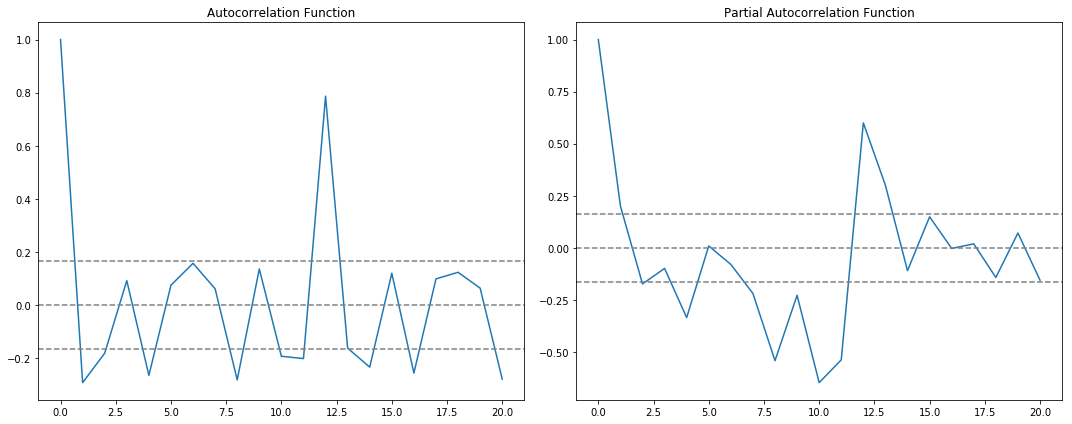

In [29]:
plt.subplot(121)
plt.plot(lag_acf[0])
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff2)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff2)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff2)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff2)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

需要注意的是这条虚线, 这是用来判断**ARIMA**模型的`p`和`q`参数的工具. 判断的原理为:

我们认为如果**相关系数**为0, 则不存在相关性. 而相关系数是符合**标准正态分布**的统计量, 即$N(0,1)$. 对于显著性水平$\alpha=0.05$, 对应的$z_{\alpha/2}=1.96$.

这是考虑其中某一个相关系数, 如果考虑多个相关系数, 即考虑每个`lag`对应的相关系的**平均水平**, 就变成了**相关系数均值**统计量的情况. 很显然, 这个均值仍服从期望为0的正态分布, 但此时的方差变为了$\frac{1}{n}$, $n$为样本量的数量, 从而`95%`置信水平对应的置信区间变为了$[-1.96/\sqrt{n}, 1.96/\sqrt{n}]$

根据上面两幅图, 得到$p=2$, $q=2$.

### ARIMA模型拟合

In [30]:
from statsmodels.tsa.arima_model import ARIMA

In [31]:
model = ARIMA(ts_log, order=(2, 2, 2))

D:\Tools\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
D:\Tools\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


注意这里使用的还是原序列经过`log`转换后的序列.

这是因为, 我们确定了二阶差分的结果为稳定序列, 在ARIMA模型中可以指定$d$参数进行差分. 当然也可以使用**差分后**, 或者**其他方法处理后**得到的**平稳序列**进行建模, 这样在ARIMA模型中指定$d$参数为0就可以了.

**需要注意的是**: 如果使用处理后的平稳序列来建模, 需要考虑**如何将ARIMA模型拟合出来的结果序列, 以及预测序列进行还原**. 平滑, 分解, 差分等方法对应着不同的还原方法.

**直接将非平稳序列投入到ARIMA模型中, 使用提前确定好的能使序列平稳的差分阶数进行处理, 得到的拟合结果是差分之后的, 需要进行差分的还原才能投入到模型中的原始的非平稳时间序列进行对比.**

In [32]:
results_ARIMA = model.fit(disp=-1)
results_ARIMA

In [33]:
" | ".join([t for t in results_ARIMA.__dir__() if not t.startswith("_")])

'aic | arfreq | arparams | arroots | bic | bse | conf_int | cov_params | data | df_model | df_resid | f_test | fittedvalues | forecast | hqic | initialize | k_ar | k_constant | k_diff | k_exog | k_ma | k_trend | llf | load | mafreq | maparams | maroots | mle_retvals | mle_settings | model | n_totobs | nobs | normalized_cov_params | params | plot_predict | predict | pvalues | remove_data | resid | save | scale | sigma2 | summary | summary2 | t_test | t_test_pairwise | tvalues | use_t | wald_test | wald_test_terms'

In [34]:
print("AIC:", results_ARIMA.aic)
print("BIC:", results_ARIMA.bic)
print("Parameters:")
print(results_ARIMA.params)

AIC: -230.4544919731087
BIC: -212.71952962750115
Parameters:
const                  -0.000078
ar.L1.D2.#Passengers   -0.579206
ar.L2.D2.#Passengers    0.035827
ma.L1.D2.#Passengers   -0.134602
ma.L2.D2.#Passengers   -0.865398
dtype: float64


Text(0.5,1,'RSS: 1.5016')

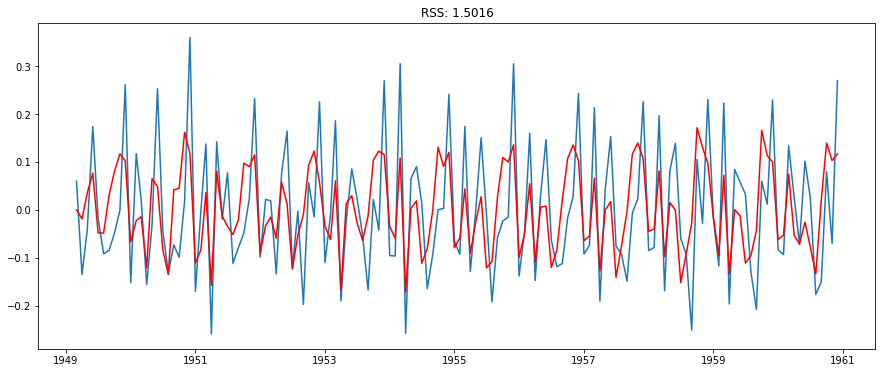

In [35]:
plt.plot(ts_log_diff2)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff2)**2))

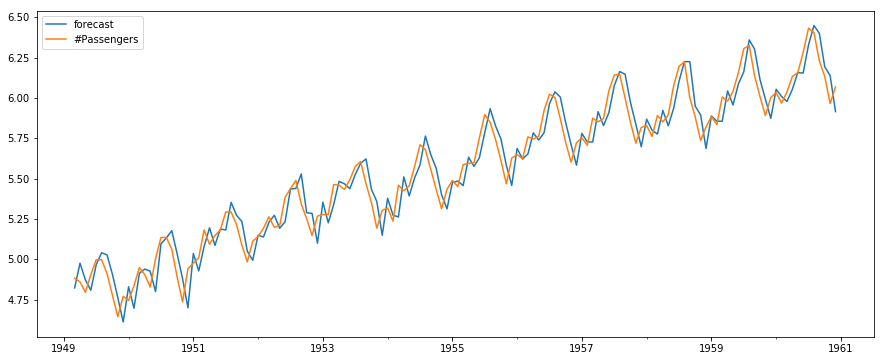

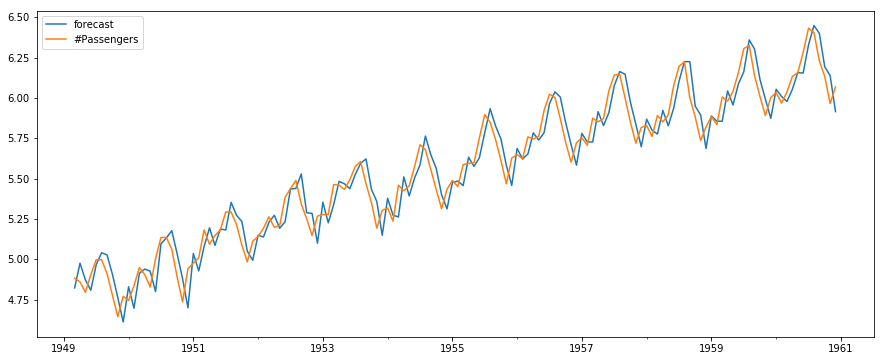

In [36]:
results_ARIMA.plot_predict()

### 还原拟合序列

使用`predict`方法进行拟合结果的输出, 注意`typ`参数, 指定了两种输出的形式:

- linear: 输出差分后的结果, 结果与`.fittedvalues`一模一样
- levels: 输入原始的结果, 已经消除了差分之后的结果

Text(0.5,1,'RMSE: 31.2558')

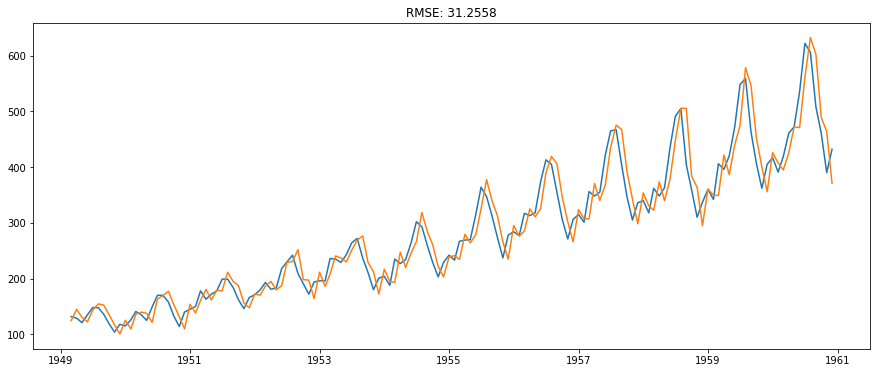

In [37]:
history_log_pred = results_ARIMA.predict(typ="levels")
history_org_pred = np.exp(history_log_pred)
plt.plot(ts[2:])
plt.plot(history_org_pred)
plt.title('RMSE: %.4f'% np.sqrt(sum((history_org_pred-ts[2:])**2)/len(ts)))

### 对未来进行预测

使用`forecast`方法对未来进行预测, 可以指定返回的未来时间点的数量.

返回三个值, 分别是:

- forecast : array
    - Array of out of sample forecasts
- stderr : array
    - Array of the standard error of the forecasts.
- conf_int : array
    - 2d array of the confidence interval for the forecast, 即每个预测点的置信区间

In [38]:
results_ARIMA.forecast(12)

(array([6.14101531, 6.10819661, 6.13524774, 6.12372575, 6.13657083,
        6.13380071, 6.14082833, 6.14150192, 6.14608714, 6.1480594 ,
        6.15156556, 6.15396998]),
 array([0.10127036, 0.16498959, 0.20231821, 0.23821591, 0.26685385,
        0.29415374, 0.31827347, 0.34119512, 0.3623683 , 0.38255293,
        0.40161437, 0.41987825]),
 array([[5.94252906, 6.33950156],
        [5.78482295, 6.43157028],
        [5.73871134, 6.53178414],
        [5.65683114, 6.59062036],
        [5.6135469 , 6.65959476],
        [5.55726998, 6.71033145],
        [5.51702379, 6.76463287],
        [5.47277176, 6.81023207],
        [5.43585832, 6.85631597],
        [5.39826943, 6.89784937],
        [5.36441585, 6.93871527],
        [5.33102373, 6.97691623]]))

In [39]:
forecast_value = pd.Series(results_ARIMA.forecast(12)[0], index=[history_org_pred.index[-1] + i for i in range(1, 13)])
forecast_value.head()

1961-01-01    6.141015
1961-02-01    6.108197
1961-03-01    6.135248
1961-04-01    6.123726
1961-05-01    6.136571
dtype: float64

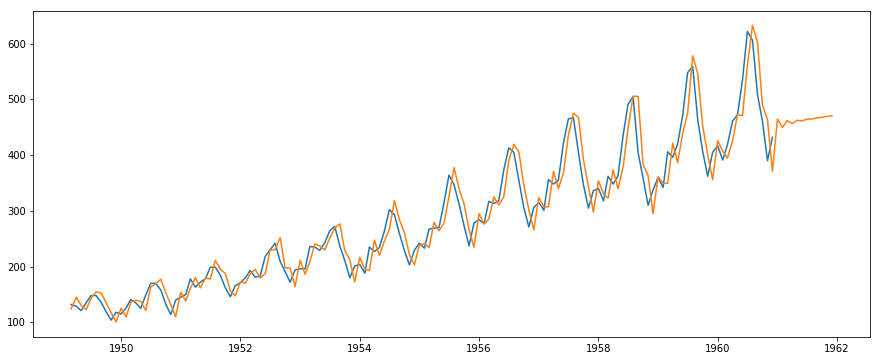

In [40]:
plt.plot(ts[2:])
plt.plot(np.exp(pd.concat([history_log_pred, forecast_value])))

结果并不是很好.